# Model3: CNN LeNet

<h3><center>LeNet Architecture</center></h3>




<img src="https://cdnpythonmachinelearning.azureedge.net/wp-content/uploads/2017/09/lenet-5-825x285.png?x31195" style="width: 1000px;"/>

In [2]:
import os
import cv2
import random
import numpy as np
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import sys
sys.path.append('../')

## Import Data in Grayscale

In [3]:
from app import features_vectors

In [4]:
path="../images/train"
x_train,y_train=features_vectors(path,True)
path="../images/test"
x_test,y_test=features_vectors(path,True)

# Reshape Data

Train Data

In [5]:
image_size=32
num_channels=1
Total=x_train.shape[0]

X_train=np.zeros([Total,image_size,image_size,num_channels])

for i,img in enumerate(x_train):
    img_reshape=img.reshape(32,32,1)
    X_train[i]=img_reshape

Test Data

In [6]:
image_size=32
num_channels=1
Total=x_test.shape[0]

X_test=np.zeros([Total,image_size,image_size,num_channels])

for i,img in enumerate(x_test):
    img_reshape=img.reshape(32,32,1)
    X_test[i]=img_reshape

#  Visualize Data

## Visualize some random images

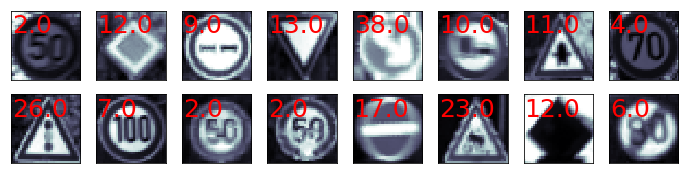

In [7]:
samples = random.sample(range(X_train.shape[0]), 16)
fig=plt.figure(figsize=(12,12))
images_sample=[]
for i,j in enumerate(samples):
    img=X_train[j]
    img=img.reshape(32,32)
    img = img.astype(np.uint8)
    d = fig.add_subplot(8,8, i+1, xticks=[], yticks=[])
    d.imshow(img, cmap=plt.cm.bone)  
    d.text(0,10,str(y_train[j]),color="red",fontsize=25)

# Preprocessing Data

# Shuffle Data

In [8]:
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train, random_state=100)
X_test, y_test= shuffle(X_test, y_test, random_state=100) 

## One Hot Encode Target Vector

In [9]:
from sklearn.preprocessing import OneHotEncoder

onehot_encoder = OneHotEncoder(sparse=False)  
y_train= y_train.reshape(len(y_train), 1) 
y_test= y_test.reshape(len(y_test), 1) 

y_train = onehot_encoder.fit_transform(y_train)
y_test= onehot_encoder.fit_transform(y_test)

# Create and Train LeNet model

In [22]:
num_labels=43
image_size=32
batch_size = 97
patch_size1=5
patch_size2=5
num_channels=1
Num_Filters1=6
Num_Filters2=16
num_hidden1=120
num_hidden2=84

graph = tf.Graph()

with graph.as_default():

     # Input data.
            
    tf_train_dataset = tf.placeholder(tf.float32, shape=(None, image_size, image_size, num_channels),name="x")
    tf_train_labels = tf.placeholder(tf.float32, shape=(None, num_labels))
    tf_test_dataset = tf.constant(X_test)
    
    tf_train_dataset = tf.cast(tf_train_dataset, tf.float32)
    tf_train_labels = tf.cast(tf_train_labels, tf.float32)
    tf_test_dataset = tf.cast(tf_test_dataset, tf.float32)
    
    def model(x):   
        mu = 0
        sigma = 0.1

        # L1 Convolutional. in= 32x32x1 / out = 28x28x6.
        Shape_C1=[patch_size1,patch_size1,num_channels,Num_Filters1]
        weigths_C1=tf.Variable(tf.truncated_normal(Shape_C1,mean = mu, stddev = sigma))
        bias_C1=tf.Variable(tf.zeros(Num_Filters1))

        C1=tf.nn.conv2d(x,weigths_C1,strides=[1, 1, 1, 1],padding='VALID')
        C1+=bias_C1 
        C1=tf.nn.sigmoid(C1)

        #SubSampling  out 14*14*6

        S2=tf.nn.max_pool(C1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

        # L2: Convolutional. Output = 10x10x16.

        Shape_C2=[patch_size2,patch_size2,Num_Filters1,Num_Filters2]
        weigths_C2=tf.Variable(tf.truncated_normal(Shape_C2, mean = mu, stddev = sigma))
        bias_C2=tf.Variable(tf.zeros(Num_Filters2))

        C2=tf.nn.conv2d(S2,weigths_C2,strides=[1, 1, 1, 1],padding='VALID')
        C2+=bias_C2 
        C2=tf.nn.relu(C2)

        S4=tf.nn.max_pool(C2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

         #Flatten Layer

        flatten_layer=flatten(S4)

        Shape_Fc1=[400,num_hidden1]
        weights_Fc1=tf.Variable(tf.truncated_normal(Shape_Fc1,stddev=0.05))
        bias_Fc1=tf.Variable(tf.zeros(num_hidden1))
        Fc1=tf.nn.relu(tf.matmul(flatten_layer,weights_Fc1))+bias_Fc1

        #Fully Connected Layer 2

        Shape_Fc2=[num_hidden1,num_hidden2]
        weights_Fc2=tf.Variable(tf.truncated_normal(Shape_Fc2,stddev=0.05))
        bias_Fc2=tf.Variable(tf.zeros(num_hidden2))
        Fc2=tf.nn.relu(tf.matmul(Fc1,weights_Fc2))+bias_Fc2

         #Prediction Layer
        Shape_Pl=[num_hidden2,num_labels]
        weights_Pl=tf.Variable(tf.truncated_normal(Shape_Pl,stddev=0.05))
        bias_Pl=tf.Variable(tf.zeros(num_labels))
        out=tf.matmul(Fc2,weights_Pl)+bias_Pl
        return out
    
      
    logits = model(tf_train_dataset)
    prediction=tf.nn.softmax(logits)
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits)
    loss = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate = 0.001).minimize(loss)
    train_prediction = tf.nn.softmax(logits)
    prediction = tf.argmax(train_prediction, 1, name='predict')
    saver = tf.train.Saver()
    
    
    
    
def accuracy(predictions, labels):
  return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])


#saver = tf.train.Saver()

num_steps = 3000

with tf.Session(graph=graph) as session:
      tf.global_variables_initializer().run()
      print('Initialized')
      for step in range(num_steps):
        offset = (step * batch_size) % (y_train.shape[0] - batch_size)
        batch_data = X_train[offset:(offset + batch_size), :, :, :]
        batch_labels = y_train[offset:(offset + batch_size), :]
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run(
          [optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 1000 == 0):
          print('Minibatch loss at step %d: %f' % (step, l))
          print('Minibatch accuracy: %.1f%%' % accuracy(predictions, batch_labels))
      saver.save(session, '../models/model3/saved/LeNet.ckpt')
      print("Model saved") 

           
    

Initialized
Minibatch loss at step 0: 3.762228
Minibatch accuracy: 2.1%
Minibatch loss at step 1000: 0.002899
Minibatch accuracy: 100.0%
Minibatch loss at step 2000: 0.000381
Minibatch accuracy: 100.0%
Model saved


# Evaluate Model

## Training Data

In [23]:
sess = tf.Session()
saver = tf.train.import_meta_graph('../models/model3/saved/LeNet.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint('../models/model3/saved'))
graph = tf.get_default_graph()
x = graph.get_tensor_by_name("x:0")
prediction = graph.get_tensor_by_name("predict:0")
feed_dict = {x: X_train}
Prediction_restored=sess.run([prediction],feed_dict=feed_dict)
matches_train=(Prediction_restored[0]==np.argmax(y_train,1))
accuracy_train=(sum(matches_train)/y_train.shape[0])*100
print(accuracy_train)

INFO:tensorflow:Restoring parameters from ../models/model3/saved/LeNet.ckpt
98.76288659793815


## Test Data

In [24]:
sess = tf.Session()
saver = tf.train.import_meta_graph('../models/model3/saved/LeNet.ckpt.meta')
saver.restore(sess, tf.train.latest_checkpoint('../models/model3/saved'))
graph = tf.get_default_graph()
x = graph.get_tensor_by_name("x:0")
prediction = graph.get_tensor_by_name("predict:0")
feed_dict = {x: X_test}
Prediction_restored=sess.run([prediction],feed_dict=feed_dict)
matches_test=(Prediction_restored[0]==np.argmax(y_test,1))
accuracy_test=(sum(matches_test)/y_test.shape[0])*100
print(accuracy_test)

INFO:tensorflow:Restoring parameters from ../models/model3/saved/LeNet.ckpt
72.42798353909465


# Visualize Predictions

In [25]:
dic_labels={0: '0',1: '1',2: '2',3: '3',4: '4',5: '5',6: '6',7: '7',8: '8',9: '9',\
        10: '10',11: '11',12: '12',13: '13',14: '14',15: '15',16: '16',17: '17',\
        18: '18',19: '19',20: '20',21: '21',22: '22',23: '23',24: '24',25: '25',\
        26: '26',27: '27',28: '28',29: '29',30: '30',31: '31',32: '32',33: '33',\
        34: '34',35: '35',36: '36',37: '37',38: '38',39: '39',40: '40',41: '41',\
        42: '42'}

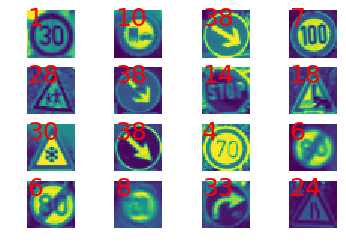

In [32]:
def visualize_predictions(dataset, labels):
  labels=np.argmax(labels, 1)
  items = random.sample(range(len(labels)), 16)
  for i, item in enumerate(items):
    plt.subplot(4, 4, i+1)
    plt.axis('off')
    plt.text(0,10,dic_labels[labels[item]],color="red",fontsize=25)
    img=dataset[item]
    img=img.reshape(32,32)
    img = img.astype(np.uint8)
    plt.imshow(img)

pred=np.round(predictions)   
visualize_predictions(batch_data,pred)